# Modelo de inteligencia artificial de PawSense

PawSense es una aplicación para predecir con la mayor precisión posible la mezcla de raza de tu perro. Para ello hemos basado la estrategia de aprendizaje de el modelo en la mejor forma de predecir las razas de un perro según el artículo de **La Vanguardia**.

Enlace al artículo: <https://www.lavanguardia.com/mascotas/20220215/8055065/descubre-mezcla-perro-mestizo-nbs.html>

## Fase 1: Preparación del entorno

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
import xml.etree.ElementTree as ET
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ==========================================
# Fase 1: Preparación del entorno (GPU RTX 3060)
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")
if torch.cuda.is_available():
    print(f"🚀 GPU detectada: {torch.cuda.get_device_name(0)}")
    # Optimizador de kernels para Windows/NVIDIA
    torch.backends.cudnn.benchmark = True

✅ Usando dispositivo: cuda
🚀 GPU detectada: NVIDIA GeForce RTX 3060


## Fase 2: Ingeniería de datos.

Aplicamos recorte de las imágenes para que el modelo aprenda exclusivamente de los perros no de otros posibles objetos de la foto (coches, personas, árboles, etc)

In [4]:
# Patron buscar subcarpetas
xml_pattern = r"dataset_perros/annotations/Annotation/**/*"

# Para cada path parsea arquitectura xml y de ahi obtenemos desde la raiz las medidas del perro en las imagenes
for xmlpath in glob.glob(xml_pattern, recursive=True):
    # Para que no se salga de la carpeta
    if os.path.isdir(xmlpath):
        continue

    try:
        # Estructura, raiz y objeto
        tree = ET.parse(xmlpath)
        root = tree.getroot()

        obj = root.find('object')

        if obj is not None:

            # Sacamos medidas del perro en la foto
            box = obj.find('bndbox')
            raza = obj.find('name').text

            xmin = int(box.find('xmin').text)
            xmax = int(box.find('xmax').text)
            ymin = int(box.find('ymin').text)
            ymax = int(box.find('ymax').text)

            # En vez de coger el nombre del xml (había xml con nombres distinto del nombre de archivos de imágenes) lo coge directamente del archivo
            xml_filename = os.path.basename(xmlpath)
            imgname = os.path.splitext(xml_filename)[0] # Nombre archivo sin extension

            # El nombre de la carpeta padre del xml debe coincidir con la carpeta de la imagen
            imgfoldername = os.path.basename(os.path.dirname(xmlpath))

            # Patron para buscar imágenes por carpeta e imagen obtenida del nombre del archivo
            img_pattern = rf"dataset_perros/images/Images/{imgfoldername}/{imgname}.jpg"

            encontrados = glob.glob(img_pattern)
            if not encontrados:
                print(f"Procesando archivo: {xmlpath}")
                print(f"❌ No se encontró imagen para: {imgname} en {imgfoldername}")

            # Para cada path abre la imagen, asegura de que este en colores, redimensiona a lo especificado en cml (por si acaso), reajusta calidad y recorta la imágen.
            for imgpath in glob.glob(img_pattern, recursive=True):
                img = Image.open(imgpath).convert('RGB')

                # Reajustar medidas de imagen para evitar problemas de recorte
                width, height = img.size
                xml_w = int(root.find('size/width').text)
                xml_h = int(root.find('size/height').text)
                if width != xml_w or height != xml_h:
                    img = img.resize((xml_w, xml_h), Image.LANCZOS)

                # Recorte de imágen
                img_final = img.crop((xmin, ymin, xmax, ymax)).resize((224, 224), Image.LANCZOS)

                # Crea directorio con carpetas de nombres de raza
                output_dir = os.path.join("dataset_recortado", raza)
                os.makedirs(output_dir, exist_ok=True)

                # Guarda imágenes
                save_path = os.path.join(output_dir, f"{imgname}.jpg")
                img_final.save(save_path)
    except Exception as e:
        print(f"Saltando {xmlpath} por error: {e}")




## Fase 3: EDA - Visualización de datos e imágenes.

- Gráfico de barras del top 10 y bottom 10 de razas para ver si hay desequilibrio.

- Mostrar fotos y clases para la clasificación

- Gráfico de "Relación de Aspecto" (Ancho vs Alto). Los Galgos son altos/finos, los Bulldogs son anchos. Esto justifica usar EfficientNet.

## Fase 4: Preprocesamiento y Aumento

In [2]:
batch_size = 32

# Preprocesamiento y Data Augmentation de Train
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalización ImageNet
])

# Normalización de datos de validación
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Cargar dataset y dividir
full_dataset = datasets.ImageFolder("dataset_recortado")
train_size = int(0.8 * len(full_dataset)) # 80%
val_size = len(full_dataset) - train_size # 20%

# Aplicar transformaciones por separado
indices = torch.randperm(len(full_dataset)).tolist()
train_ds = Subset(datasets.ImageFolder("dataset_recortado", transform=train_transforms), indices[:train_size])
val_ds = Subset(datasets.ImageFolder("dataset_recortado", transform=val_transforms), indices[train_size:])

# Carga de datos final para el entrenamiento
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Fase 5: Construcción del Modelo

+ Base: EfficientNetB0(weights='imagenet', include_top=False).
+ Capas Superiores (Tu "Cabeza"):
+ GlobalAveragePooling2D: Para reducir variables y evitar el overfitting (el "aplanado inteligente").
+ Dropout (0.3): Para que el equipo de neuronas trabaje unido.
+ Dense (120, activation='softmax'): Para obtener los porcentajes de probabilidad por raza.



In [3]:
print("Cargando EfficientNetB0...")
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Congelar base
for param in model.parameters():
    param.requires_grad = False

# Personalizar la cabeza (120 razas)
# Primero, obtenemos cuántos datos salen del cuerpo del modelo (son 1280 en EfficientNetB0)
num_ftrs = model.classifier[1].in_features

model.classifier[1] = nn.Sequential(
    # Apaga aleatoriamente el 20% de las neuronas para evitar que el modelo memorice las fotos (previene el overfitting)
    nn.Dropout(p=0.2, inplace=True),
    # Conecta los 1280 datos de entrada con nuestras 120 salidas
    nn.Linear(num_ftrs, 120)
)
model = model.to(device)

Cargando EfficientNetB0...


In [4]:
from torchinfo import summary
# Batch size, Channels, Height, Width
summary(model, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], verbose=0)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 120]                 --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [5]:
class EarlyStopping:
    """Para el entrenamiento si la valid loss no mejora después de 'patience' épocas."""
    def __init__(self, patience=5, min_delta=0, path='model/modelo_perros_pytorch.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Guarda el modelo cuando la validation loss disminuye.'''
        torch.save(model.state_dict(), self.path)

# Fase 6: Entrenamiento en Dos Etapas
Etapa A: El Calentamiento (Transfer Learning)
+ Acción: congelamos el modelo base.
+ Optimizer: Adam con Learning Rate alto $($10^{-3}$)$.
+ Épocas: 5-8.

Por qué: Para que la cabeza aprenda lo básico sin molestar al experto.

Etapa B: El Ajuste Fino (Fine-Tuning)
+ Acción: Descongelamos la capa base.
+ Optimizer: Adam con Learning Rate bajísimo $($10^{-5}$)$.
+ Épocas: 20-30 (pero aquí actúa el vigilante).


In [6]:
criterion = nn.CrossEntropyLoss() # Definimos la "regla de medida" del error (Loss Function)
# Activamos el Escalador de Gradientes para Precisión Mixta (AMP)
# permite que la GPU use menos memoria y trabaje más rápido sin perder precisión en el entrenamiento.
scaler = torch.amp.GradScaler('cuda') 
# Almacenamos la pérdida y la exactitud para luego dibujar las gráficas.
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

def train_epoch(model, loader, optimizer, scaler, epoch_idx):
    """Función para entrenar el modelo durante una época completa"""

    # Ponemos el modelo en modo entrenamiento (activa Dropout)
    model.train()
    running_loss, correct = 0.0, 0

    # Envolver el loader con tqdm para ver el progreso por batch
    pbar = tqdm(loader, desc=f"Epoch {epoch_idx} [TRAIN]", unit="batch")
    
    for images, labels in pbar:

        images, labels = images.to(device), labels.to(device) # Movemos los datos a la memoria de la GPU

        optimizer.zero_grad() # Limpiamos los gradientes anteriores para no acumular errores

        # --- Inicio de Precisión Mixta ---
        with torch.amp.autocast('cuda'):
            outputs = model(images) # El modelo hace su predicción (Forward Pass)
            loss = criterion(outputs, labels) # Calculamos qué tan equivocado estuvo (Loss)

        #El escalador ajusta la pérdida para que sea compatible con la precisión de la GPU
        # y luego calculamos la dirección del error (Backpropagation)
        scaler.scale(loss).backward()

        scaler.step(optimizer) # El optimizador da un "paso" y ajusta los pesos del modelo
        scaler.update() # Actualizamos el escalador para el siguiente lote
        
        # --- Estadísticas en vivo ---
        running_loss += loss.item()
        _, pred = outputs.max(1) # Obtenemos la raza con mayor probabilidad
        correct += pred.eq(labels).sum().item() # Contamos cuántas acertó
        
        # Actualizar información en la barra de progreso
        pbar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/((pbar.n+1)*loader.batch_size)})

    # Devolvemos el promedio de pérdida y precisión de toda la época    
    return running_loss/len(loader), 100.*correct/len(loader.dataset)

def validate_epoch(model, loader):
    """Función para evaluar el modelo sin entrenarlo"""
    # Ponemos el modelo en modo evaluación (desactiva Dropout para mayor estabilidad)
    model.eval() 
    running_loss, correct = 0.0, 0

    # Barra de progreso para la validación (se borra al terminar para no llenar la pantalla)
    pbar = tqdm(loader, desc="Validando", unit="batch", leave=False)

    # Desactivamos el cálculo de gradientes para que la GPU vaya más rápido y use menos RAM
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

           # El modelo solo predice, no aprende aquí
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
    # Devolvemos los resultados para compararlos con los de entrenamiento.        
    return running_loss/len(loader), 100.*correct/len(loader.dataset)

## Etapa A: Calentamiento (Transfer Learning)

El objetivo de esta etapa es entrenar únicamente la nueva "cabeza" que añadimos (las 120 razas) mientras el resto del cuerpo del modelo (EfficientNet) sigue congelado.

In [7]:
# Configuramos el optimizador Adam
# IMPORTANTE: Solo le pasamos 'model.classifier.parameters()', esto le dice al optimizador que solo puede tocar los pesos de la capa final.
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3) # Usamos un Learning Rate de 1e-3 (0.001), para avanzar rápido.

for epoch in range(5):
    # Ejecutamos la función de entrenamiento para esta época
    # Obtenemos la pérdida (t_loss) y la precisión (t_acc) del entrenamiento.
    t_loss, t_acc = train_epoch(model, train_loader, optimizer, scaler, epoch+1)
    
    # Ejecutamos la validación
    v_loss, v_acc = validate_epoch(model,val_loader)

    # Guardamos los resultados en nuestro diccionario 'history'
    # Esto es lo que permite que después podamos dibujar las gráficas de Accuracy y Loss.
    for k, v in zip(history.keys(), [t_loss, t_acc, v_loss, v_acc]): history[k].append(v)

    # Imprimimos resumen rápido al terminar cada época
    print(f"✅ Final E{epoch+1} - Val Acc: {v_acc:.1f}%")

Epoch 1 [TRAIN]: 100%|██████████| 515/515 [00:50<00:00, 10.14batch/s, loss=1.89, acc=43.2]


✅ Final E1 - Val Acc: 60.8%


Epoch 2 [TRAIN]: 100%|██████████| 515/515 [00:24<00:00, 20.62batch/s, loss=1.66, acc=61.2] 


✅ Final E2 - Val Acc: 63.9%


Epoch 3 [TRAIN]: 100%|██████████| 515/515 [00:23<00:00, 21.80batch/s, loss=1.75, acc=65]   


✅ Final E3 - Val Acc: 64.5%


Epoch 4 [TRAIN]: 100%|██████████| 515/515 [00:24<00:00, 21.33batch/s, loss=1.62, acc=67.4] 


✅ Final E4 - Val Acc: 64.5%


Epoch 5 [TRAIN]: 100%|██████████| 515/515 [00:23<00:00, 21.50batch/s, loss=1.21, acc=68]   
                                                               

✅ Final E5 - Val Acc: 65.5%


## Etapa B: Ajuste Fino (Fine-Tuning)
Descongelamos las capas superiores del extractor de características (EfficientNet), y usamos un Learning Rate (lr) muy bajo de $10^{-5}$ ($0.00001$).

In [8]:
# Stage B: Fine-Tuning
print("Fase 6B: Ajuste Fino...")

# Descongelamos todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = True

# Optimizador con learning rate muy bajo para no romper lo aprendido
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Scheduler para reducir el LR si nos estancamos (ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

# Early Stopping para detener si no mejoramos
early_stopping = EarlyStopping(patience=5, path='model/modelo_perros_pytorch.pth')

epochs = 25 # Aumentamos las épocas permitidas

for epoch in range(epochs):
    # Entrenar
    t_loss, t_acc = train_epoch(model, train_loader, optimizer, scaler, epoch+1)
    
    # Validar
    v_loss, v_acc = validate_epoch(model, val_loader)
    
    # Guardar historial
    for k, v in zip(history.keys(), [t_loss, t_acc, v_loss, v_acc]): history[k].append(v)
    
    # Mostrar métricas
    print(f"✅ Final FT{epoch+1} - Val Acc: {v_acc:.1f}% | Val Loss: {v_loss:.4f}")
    
    # Actualizar Scheduler
    scheduler.step(v_loss)
    
    # Verificar Early Stopping
    early_stopping(v_loss, model)
    if early_stopping.early_stop:
        print(f"⏹️ Early Stopping activado en la época {epoch+1}")
        break

# Cargar el mejor modelo guardado por EarlyStopping
model.load_state_dict(torch.load('model/modelo_perros_pytorch.pth'))
print("Mejor modelo cargado.")


Fase 6B: Ajuste Fino...


Epoch 1 [TRAIN]: 100%|██████████| 515/515 [00:49<00:00, 10.48batch/s, loss=1.4, acc=74.6]  


✅ Final FT1 - Val Acc: 72.8% | Val Loss: 0.9019


Epoch 2 [TRAIN]: 100%|██████████| 515/515 [00:45<00:00, 11.21batch/s, loss=0.822, acc=77.7]


✅ Final FT2 - Val Acc: 75.8% | Val Loss: 0.7881


Epoch 3 [TRAIN]: 100%|██████████| 515/515 [00:46<00:00, 11.02batch/s, loss=0.42, acc=79.9] 


✅ Final FT3 - Val Acc: 77.6% | Val Loss: 0.7266


Epoch 4 [TRAIN]: 100%|██████████| 515/515 [00:46<00:00, 11.17batch/s, loss=0.431, acc=81.6]


✅ Final FT4 - Val Acc: 78.8% | Val Loss: 0.6829


Epoch 5 [TRAIN]: 100%|██████████| 515/515 [00:46<00:00, 11.14batch/s, loss=1.17, acc=82.2] 


✅ Final FT5 - Val Acc: 79.7% | Val Loss: 0.6495


Epoch 6 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.69batch/s, loss=0.88, acc=83.6] 


✅ Final FT6 - Val Acc: 80.4% | Val Loss: 0.6180


Epoch 7 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.73batch/s, loss=0.506, acc=84]  


✅ Final FT7 - Val Acc: 81.2% | Val Loss: 0.5976


Epoch 8 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.64batch/s, loss=0.551, acc=85.1]


✅ Final FT8 - Val Acc: 80.6% | Val Loss: 0.5949


Epoch 9 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.69batch/s, loss=0.547, acc=85.4]


✅ Final FT9 - Val Acc: 81.4% | Val Loss: 0.5666


Epoch 10 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.67batch/s, loss=0.381, acc=86.1]


✅ Final FT10 - Val Acc: 81.9% | Val Loss: 0.5680


Epoch 11 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.70batch/s, loss=0.868, acc=86.9]


✅ Final FT11 - Val Acc: 82.0% | Val Loss: 0.5598


Epoch 12 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.70batch/s, loss=0.943, acc=86.5]


✅ Final FT12 - Val Acc: 82.0% | Val Loss: 0.5481


Epoch 13 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.70batch/s, loss=0.584, acc=87.9]


✅ Final FT13 - Val Acc: 82.3% | Val Loss: 0.5418


Epoch 14 [TRAIN]: 100%|██████████| 515/515 [00:43<00:00, 11.71batch/s, loss=0.898, acc=88.2]


✅ Final FT14 - Val Acc: 82.1% | Val Loss: 0.5377


Epoch 15 [TRAIN]: 100%|██████████| 515/515 [00:49<00:00, 10.34batch/s, loss=0.358, acc=88.4]


✅ Final FT15 - Val Acc: 82.8% | Val Loss: 0.5262


Epoch 16 [TRAIN]: 100%|██████████| 515/515 [00:48<00:00, 10.61batch/s, loss=0.235, acc=88.8]


✅ Final FT16 - Val Acc: 82.7% | Val Loss: 0.5359


Epoch 17 [TRAIN]: 100%|██████████| 515/515 [00:46<00:00, 11.06batch/s, loss=0.33, acc=89.2] 


✅ Final FT17 - Val Acc: 83.1% | Val Loss: 0.5162


Epoch 18 [TRAIN]: 100%|██████████| 515/515 [00:47<00:00, 10.82batch/s, loss=0.428, acc=89.5]


✅ Final FT18 - Val Acc: 83.0% | Val Loss: 0.5196


Epoch 19 [TRAIN]: 100%|██████████| 515/515 [00:45<00:00, 11.40batch/s, loss=0.296, acc=90]  


✅ Final FT19 - Val Acc: 82.8% | Val Loss: 0.5191


Epoch 20 [TRAIN]: 100%|██████████| 515/515 [00:46<00:00, 11.19batch/s, loss=0.747, acc=90.5] 


✅ Final FT20 - Val Acc: 83.0% | Val Loss: 0.5173


Epoch 21 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.47batch/s, loss=0.405, acc=91.3] 


✅ Final FT21 - Val Acc: 83.4% | Val Loss: 0.5036


Epoch 22 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.63batch/s, loss=0.434, acc=90.5] 


✅ Final FT22 - Val Acc: 82.9% | Val Loss: 0.5165


Epoch 23 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.59batch/s, loss=0.483, acc=90.9] 


✅ Final FT23 - Val Acc: 83.2% | Val Loss: 0.5114


Epoch 24 [TRAIN]: 100%|██████████| 515/515 [00:46<00:00, 11.16batch/s, loss=0.18, acc=91.1]  


✅ Final FT24 - Val Acc: 83.4% | Val Loss: 0.5076


Epoch 25 [TRAIN]: 100%|██████████| 515/515 [00:44<00:00, 11.59batch/s, loss=0.341, acc=91]   
                                                               

✅ Final FT25 - Val Acc: 83.4% | Val Loss: 0.5114
Mejor modelo cargado.


## Guardamos el modelo

In [9]:
torch.save(model.state_dict(), "model/modelo_perros.pth")
with open("model/class_names.json", "w") as f: json.dump(full_dataset.classes, f)
print("\n✅ Completado. Modelo y gráficas guardados.")


✅ Completado. Modelo y gráficas guardados.


# Fase 7: Evaluación y Conclusiones
Gráficas de Entrenamiento: Dibuja las curvas de Loss y Accuracy. Identifica el punto donde el Early Stopping paró la máquina.
Análisis de "Mezclas" (La Vanguardia): Crea una función que reciba una foto y te devuelva el Top 5 de probabilidades.
Ejemplo: "60% Golden, 30% Labrador, 10% Otros". Esto demuestra que el modelo entiende que el perro tiene rasgos de varios clados.


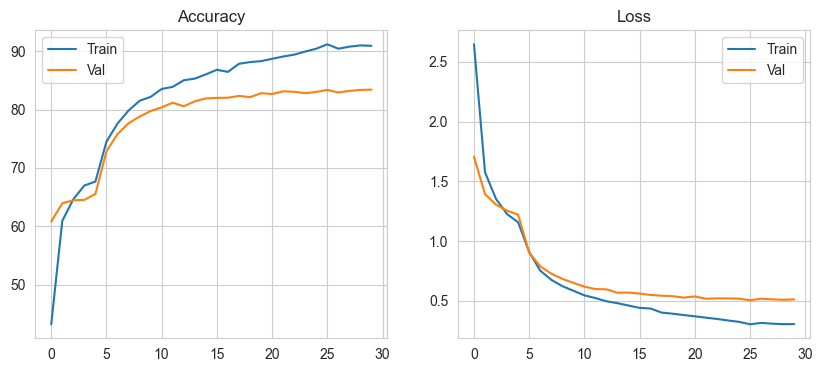

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.plot(history['train_acc'], label='Train'); plt.plot(history['val_acc'], label='Val'); plt.legend(); plt.title('Accuracy')
plt.subplot(1, 2, 2); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.legend(); plt.title('Loss')
plt.savefig('evaluacion/grafica_final.png')
plt.show()

🔍 Generando predicciones para la matriz...


Progreso: 100%|██████████| 129/129 [00:17<00:00,  7.40it/s]


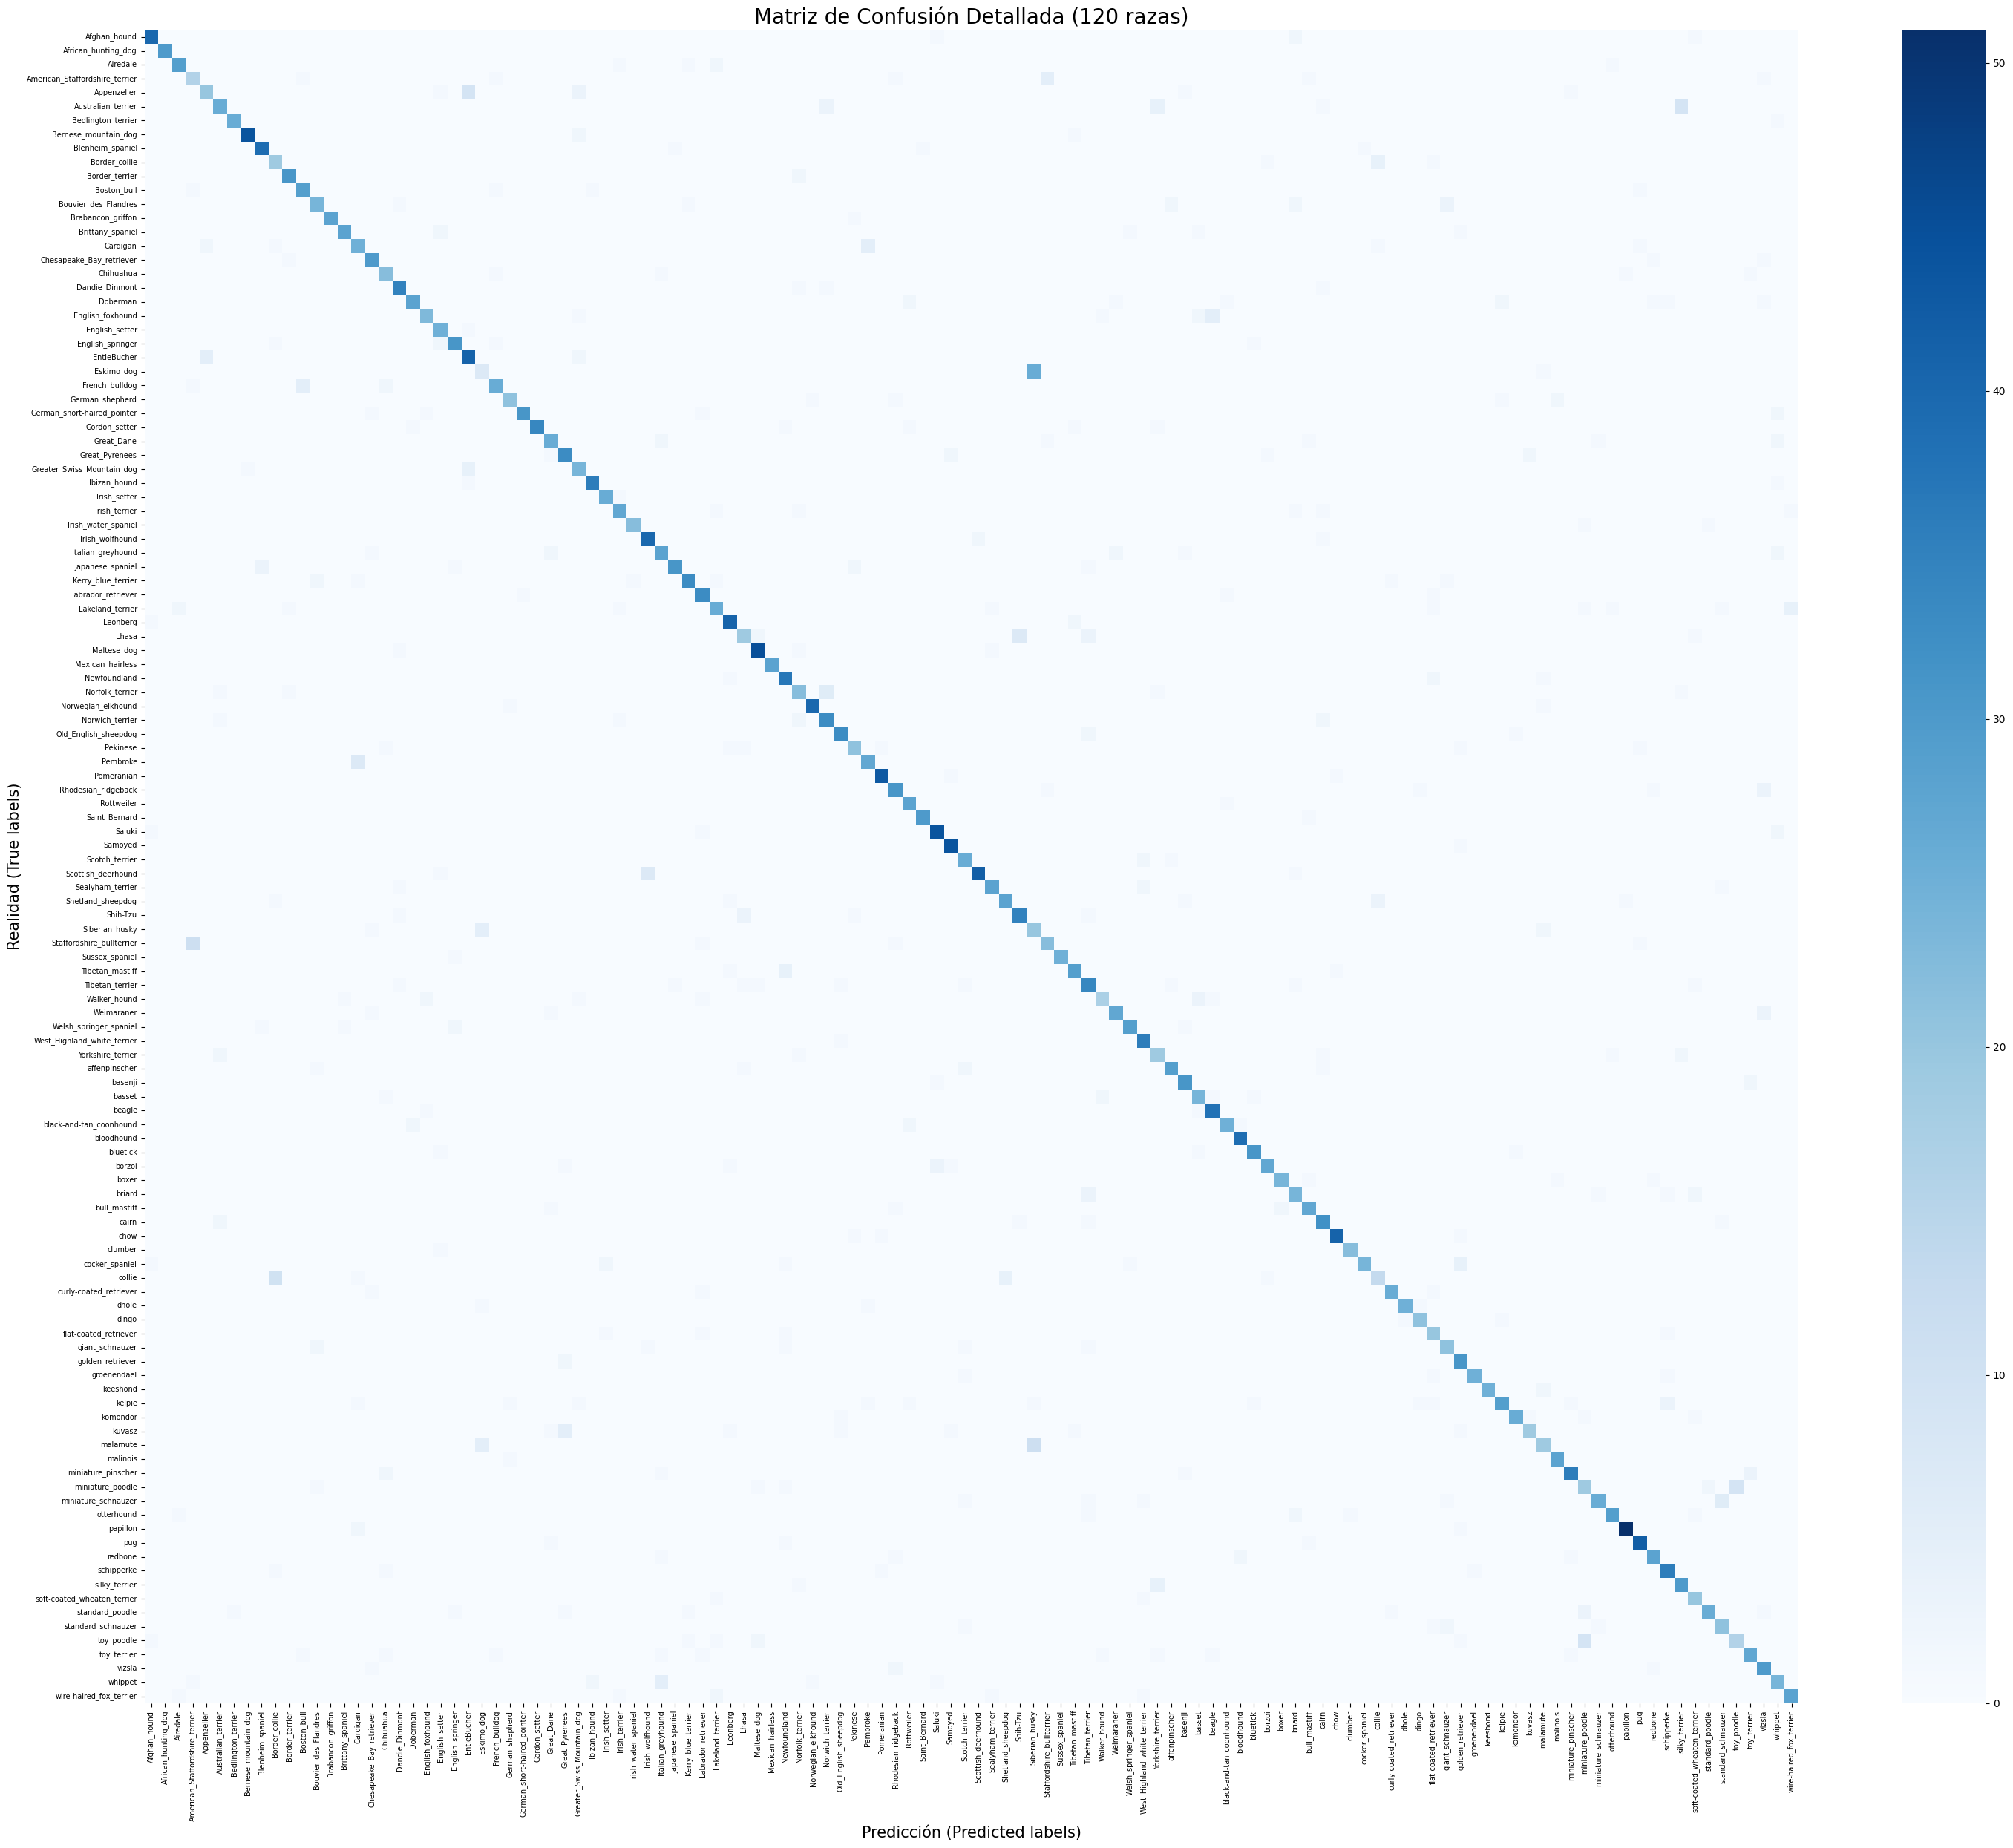

In [11]:
from sklearn.metrics import confusion_matrix

def mostrar_matriz_confusion(model, loader, class_names):
    # 1. Ponemos el modelo en modo evaluación
    model.eval()
    y_true = []
    y_pred = []
    
    # 2. Recolectamos todas las predicciones del set de validación
    print("🔍 Generando predicciones para la matriz...")
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Progreso"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # 3. Calculamos la matriz con sklearn
    cm = confusion_matrix(y_true, y_pred)
    
    # 4. Visualización con Seaborn
    # Aumentamos ligeramente el ancho para dar espacio a los nombres largos de las razas
    plt.figure(figsize=(30, 25)) 
    
    sns.heatmap(
        cm, 
        annot=False, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names, # ACTIVADO: Muestra nombres en el eje X
        yticklabels=class_names  # ACTIVADO: Muestra nombres en el eje Y
    )
    
    # Ajustamos la rotación y el tamaño de la fuente para que no se amontonen los 120 nombres
    plt.xticks(rotation=90, fontsize=7) 
    plt.yticks(fontsize=7)
    
    plt.title('Matriz de Confusión Detallada (120 razas)', fontsize=20)
    plt.ylabel('Realidad (True labels)', fontsize=15)
    plt.xlabel('Predicción (Predicted labels)', fontsize=15)
    
    # Usamos tight_layout para que los nombres de las razas no se corten al guardar la imagen
    plt.tight_layout()
    plt.savefig('evaluacion/matriz_confusion_nombres.png', dpi=300) # dpi=300 para alta definición
    plt.show()
    
    return y_pred, y_true

# Llamada a la función usando las clases del dataset
y_pred, y_true = mostrar_matriz_confusion(model, val_loader, full_dataset.classes)

In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# 1. Calculamos la matriz numérica (cm)
cm = confusion_matrix(y_true, y_pred)

# 2. Creamos el DataFrame
# Usamos 'full_dataset.classes' para que las filas (Realidad) y 
# las columnas (Predicción) tengan los nombres de las 120 razas.
df_cm = pd.DataFrame(cm, index=full_dataset.classes, columns=full_dataset.classes)

# 3. Guardar a CSV
# Esto es lo más recomendable para poder filtrar y buscar razas en Excel.
df_cm.to_csv("evaluacion/matriz_confusion_perros.csv")
print("Matriz guardada correctamente en 'evaluacion/matriz_confusion_perros.csv'")

# 4. Mostrar las primeras 5 filas en el notebook
df_cm.head()

Matriz guardada correctamente en 'evaluacion/matriz_confusion_perros.csv'


,Afghan_hound,African_hunting_dog,Airedale,American_Staffordshire_terrier,Appenzeller,Australian_terrier,Bedlington_terrier,Bernese_mountain_dog,Blenheim_spaniel,Border_collie,...,schipperke,silky_terrier,soft-coated_wheaten_terrier,standard_poodle,standard_schnauzer,toy_poodle,toy_terrier,vizsla,whippet,wire-haired_fox_terrier
Afghan_hound,40,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
African_hunting_dog,0,30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Airedale,0,0,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American_Staffordshire_terrier,0,0,0,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Appenzeller,0,0,0,0,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


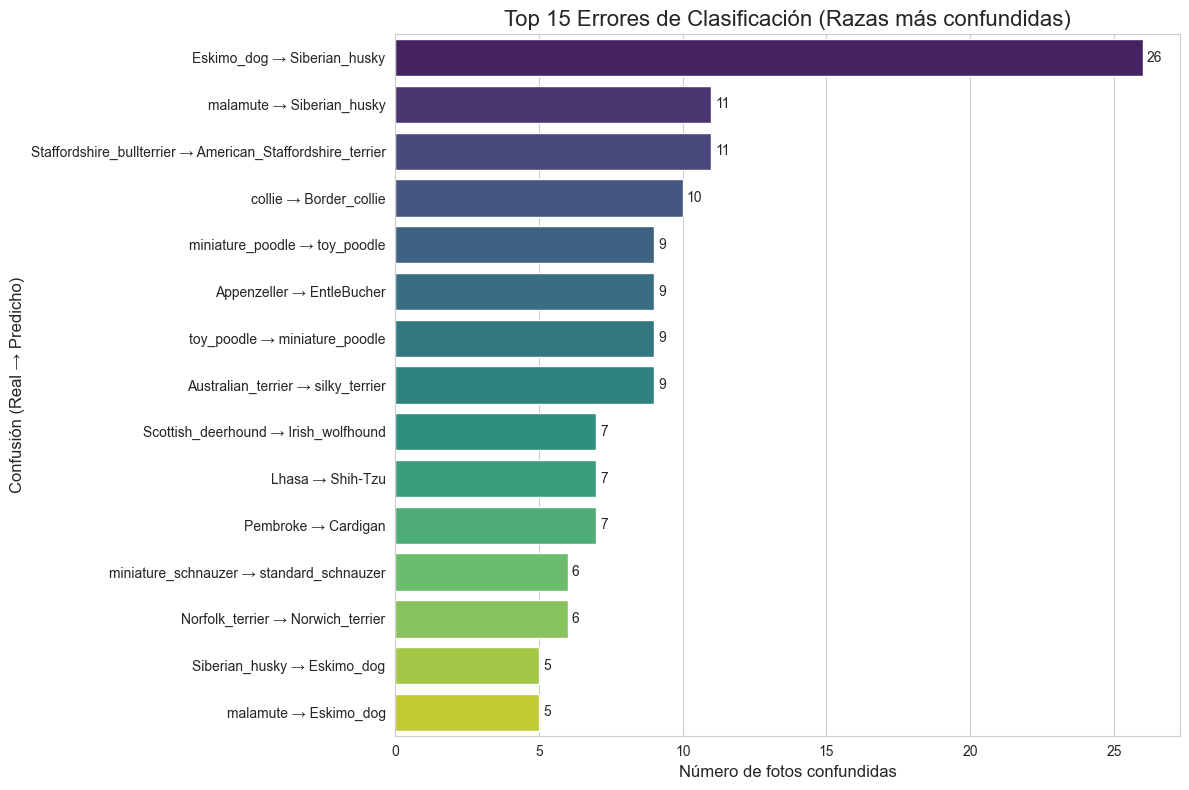

In [13]:

def graficar_mayores_confusiones(y_true, y_pred, class_names, top_n=15):
    # 1. Calculamos la matriz de confusión
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # 2. Convertimos a un DataFrame para manipularlo fácilmente
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # 3. "Limpiamos" la diagonal (ponemos a 0 los aciertos)
    # Solo nos interesan los errores para esta gráfica.
    np.fill_diagonal(cm, 0)
    
    # 4. Extraemos los pares de razas y sus conteos de error
    confusiones = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm[i, j] > 0:
                confusiones.append({
                    'Real': class_names[i],
                    'Predicho': class_names[j],
                    'Cantidad': cm[i, j],
                    'Pareja': f"{class_names[i]} → {class_names[j]}"
                })
    
    # 5. Ordenamos por cantidad de errores y tomamos los N mejores
    df_confusiones = pd.DataFrame(confusiones).sort_values(by='Cantidad', ascending=False).head(top_n)
    
    # 6. Creamos la gráfica
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Gráfico de barras horizontales
    barras = sns.barplot(
        x='Cantidad', 
        y='Pareja', 
        data=df_confusiones, 
        hue='Pareja',
        palette='viridis'
    )
    
    plt.title(f'Top {top_n} Errores de Clasificación (Razas más confundidas)', fontsize=16)
    plt.xlabel('Número de fotos confundidas', fontsize=12)
    plt.ylabel('Confusión (Real → Predicho)', fontsize=12)
    
    # Añadimos el número exacto al final de cada barra
    for i in barras.containers:
        barras.bar_label(i, padding=3)

    plt.tight_layout()
    plt.savefig('evaluacion/mayores_confusiones.png')
    plt.show()

# Llamada a la función usando los datos obtenidos anteriormente
graficar_mayores_confusiones(y_true, y_pred, full_dataset.classes, top_n=15)

In [14]:
from sklearn.metrics import classification_report

# 1. Generamos el informe como un diccionario en lugar de una cadena de texto
# 'output_dict=True' es la clave para poder pasarlo a un DataFrame.
reporte_dict = classification_report(
    y_true, 
    y_pred, 
    target_names=full_dataset.classes, 
    output_dict=True
)

# 2. Creamos el DataFrame
# Transponemos (.T) para que las razas aparezcan en las filas y las métricas en las columnas.
df_reporte = pd.DataFrame(reporte_dict).T

# 3. Limpieza y formato
# Redondeamos a 2 decimales y ordenamos por 'f1-score' para ver las razas que más fallan primero.
df_reporte = df_reporte.sort_values(by='f1-score', ascending=True)

# 4. Guardar a CSV (opcional pero recomendado)
df_reporte.to_csv("evaluacion/informe_detallado_razas.csv")
print("Informe detallado guardado en 'evaluacion/informe_detallado_razas.csv'")

# 5. Visualizar el Top 10 de razas con más dificultades
df_reporte.head(10)

Informe detallado guardado en 'evaluacion/informe_detallado_razas.csv'


,precision,recall,f1-score,support
Eskimo_dog,0.388889,0.205882,0.269231,34.0
Siberian_husky,0.344828,0.714286,0.465116,28.0
collie,0.619048,0.448276,0.520000,29.0
miniature_poodle,0.558824,0.575758,0.567164,33.0
toy_poodle,0.640000,0.516129,0.571429,31.0
American_Staffordshire_terrier,0.533333,0.615385,0.571429,26.0
malamute,0.730769,0.542857,0.622951,35.0
Appenzeller,0.740741,0.571429,0.645161,35.0
Border_collie,0.575758,0.760000,0.655172,25.0
Lhasa,0.760000,0.593750,0.666667,32.0
